# 1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
from tensorflow.keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasRegressor

from kerastuner.tuners import RandomSearch, Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import time
import warnings
warnings.filterwarnings('ignore')

2025-04-24 21:17:25.281985: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 21:17:25.347085: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 21:17:25.428721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745504245.502084 3441381 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745504245.523370 3441381 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745504245.684600 3441381 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# 2 Dataset

## 2.1 Dataset Info

In [2]:
data = pd.read_csv('./datasets/sugar_consumption_dataset.csv')
data.head()

,Country,Year,Country_Code,Continent,Region,Population,GDP_Per_Capita,Per_Capita_Sugar_Consumption,Total_Sugar_Consumption,Sugar_From_Sugarcane,...,Obesity_Rate,Sugar_Imports,Sugar_Exports,Avg_Retail_Price_Per_Kg,Gov_Tax,Gov_Subsidies,Education_Campaign,Urbanization_Rate,Climate_Conditions,Sugarcane_Production_Yield
0,France,1972,FRA,Europe,Western Europe,2.617306e+08,8692.631696,12.827741,3.357413e+06,68.422963,...,34.094017,5.401670e+06,2.358929e+06,3.864020,0.0,0,0.0,34.503398,3,52.433972
1,Australia,2003,AUS,Oceania,Australia & New Zealand,1.737965e+08,6859.195960,21.362632,3.712750e+06,55.432564,...,16.040118,3.418790e+06,9.694348e+06,3.282101,0.0,0,0.0,31.783067,4,58.382055
2,Germany,1963,DEU,Europe,Western Europe,1.236366e+08,22075.950575,32.077485,3.965951e+06,86.466120,...,14.405741,8.987281e+06,5.451632e+06,1.097687,0.0,0,0.0,51.551345,1,32.184735
3,France,1965,FRA,Europe,Western Europe,2.989961e+08,3728.027392,47.648930,1.424685e+07,69.806707,...,38.499271,5.179004e+06,8.048500e+06,2.761297,0.0,0,0.0,80.386281,2,84.296019
4,Germany,2010,DEU,Europe,Western Europe,7.341531e+06,40420.973962,23.214343,1.704288e+05,63.772278,...,36.190977,6.463439e+06,7.062910e+06,4.219431,0.0,0,1.0,49.701153,3,66.110815


In [3]:
data.info()
data.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       10000 non-null  object 
 1   Year                          10000 non-null  int64  
 2   Country_Code                  10000 non-null  object 
 3   Continent                     10000 non-null  object 
 4   Region                        10000 non-null  object 
 5   Population                    10000 non-null  float64
 6   GDP_Per_Capita                10000 non-null  float64
 7   Per_Capita_Sugar_Consumption  10000 non-null  float64
 8   Total_Sugar_Consumption       10000 non-null  float64
 9   Sugar_From_Sugarcane          10000 non-null  float64
 10  Sugar_From_Beet               10000 non-null  float64
 11  Sugar_From_HFCS               10000 non-null  float64
 12  Sugar_From_Other              10000 non-null  float64
 13  Pr

,count,mean,std,min,25%,50%,75%,max
Year,10000.0,1.991330e+03,1.842409e+01,1.960000e+03,1.976000e+03,1.991000e+03,2.007000e+03,2.023000e+03
Population,10000.0,1.501189e+08,8.646170e+07,1.005004e+06,7.434980e+07,1.500741e+08,2.250870e+08,2.999917e+08
GDP_Per_Capita,10000.0,2.524249e+04,1.419305e+04,5.004174e+02,1.321935e+04,2.515557e+04,3.755813e+04,4.999701e+04
Per_Capita_Sugar_Consumption,10000.0,3.762603e+01,1.873365e+01,5.017558e+00,2.138617e+01,3.787815e+01,5.400348e+01,6.999188e+01
Total_Sugar_Consumption,10000.0,5.650157e+06,4.599203e+06,7.387572e+03,1.882590e+06,4.369083e+06,8.484738e+06,2.090366e+07
Sugar_From_Sugarcane,10000.0,7.002854e+01,1.148125e+01,5.000520e+01,6.007236e+01,7.016734e+01,8.000797e+01,8.999469e+01
Sugar_From_Beet,10000.0,2.249456e+01,1.020729e+01,5.003532e+00,1.354409e+01,2.253287e+01,3.144876e+01,3.999972e+01
Sugar_From_HFCS,10000.0,2.981111e+01,1.724289e+01,1.760998e-03,1.474601e+01,3.010130e+01,4.457101e+01,5.999856e+01
Sugar_From_Other,10000.0,-2.233421e+01,2.298842e+01,-8.418830e+01,-3.863316e+01,-2.241324e+01,-5.925863e+00,4.071023e+01
Processed_Food_Consumption,10000.0,1.552942e+02,8.367716e+01,1.002839e+01,8.178560e+01,1.559100e+02,2.280761e+02,2.999349e+02


## 2.2 Dataset Cleaning

In [4]:
data = data[data['Country'] == 'Indonesia']
data.drop(columns=['Country_Code', 'Continent', 'Region'], inplace=True)
data.head()

,Country,Year,Population,GDP_Per_Capita,Per_Capita_Sugar_Consumption,Total_Sugar_Consumption,Sugar_From_Sugarcane,Sugar_From_Beet,Sugar_From_HFCS,Sugar_From_Other,...,Obesity_Rate,Sugar_Imports,Sugar_Exports,Avg_Retail_Price_Per_Kg,Gov_Tax,Gov_Subsidies,Education_Campaign,Urbanization_Rate,Climate_Conditions,Sugarcane_Production_Yield
24,Indonesia,2018,1.386961e+08,42222.036718,26.150079,3.626914e+06,51.626951,27.261503,19.717722,1.393824,...,24.652809,6.986661e+05,7.658653e+06,3.817329,0.0,1,0.0,83.582022,5,65.514249
37,Indonesia,1961,1.747405e+08,33179.352987,68.268972,1.192936e+07,62.042647,28.133919,56.152098,-46.328663,...,31.443198,5.529376e+06,6.464625e+05,4.664616,0.0,0,0.0,57.881396,1,55.779609
46,Indonesia,1987,1.144318e+08,14690.022502,52.882894,6.051486e+06,84.151350,37.728119,1.733398,-23.612867,...,27.890248,8.786053e+06,8.334507e+06,2.315445,0.0,0,1.0,82.273627,4,66.489665
63,Indonesia,1976,8.542037e+07,25035.795046,64.874039,5.541565e+06,56.687999,35.779883,31.762511,-24.230393,...,29.103201,2.509293e+06,2.987737e+06,0.773187,1.0,0,0.0,87.200492,1,46.101138
73,Indonesia,1969,6.377055e+07,45871.455002,34.739960,2.215386e+06,89.806138,30.608597,18.531769,-38.946503,...,9.026157,3.458636e+06,7.417685e+06,4.907764,0.0,0,0.0,62.428621,2,40.733744


In [5]:
data.info()
data.describe().T

<class 'pandas.core.frame.DataFrame'>
Index: 877 entries, 24 to 9993
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       877 non-null    object 
 1   Year                          877 non-null    int64  
 2   Population                    877 non-null    float64
 3   GDP_Per_Capita                877 non-null    float64
 4   Per_Capita_Sugar_Consumption  877 non-null    float64
 5   Total_Sugar_Consumption       877 non-null    float64
 6   Sugar_From_Sugarcane          877 non-null    float64
 7   Sugar_From_Beet               877 non-null    float64
 8   Sugar_From_HFCS               877 non-null    float64
 9   Sugar_From_Other              877 non-null    float64
 10  Processed_Food_Consumption    877 non-null    float64
 11  Avg_Daily_Sugar_Intake        877 non-null    float64
 12  Diabetes_Prevalence           877 non-null    float64
 13  Obesity_

,count,mean,std,min,25%,50%,75%,max
Year,877.0,1.991854e+03,1.845373e+01,1.960000e+03,1.977000e+03,1.992000e+03,2.009000e+03,2.023000e+03
Population,877.0,1.497409e+08,8.548674e+07,1.157825e+06,7.504695e+07,1.482956e+08,2.253596e+08,2.999473e+08
GDP_Per_Capita,877.0,2.432337e+04,1.398669e+04,5.750434e+02,1.229835e+04,2.386450e+04,3.624651e+04,4.990260e+04
Per_Capita_Sugar_Consumption,877.0,3.809436e+01,1.912300e+01,5.048016e+00,2.090501e+01,3.920328e+01,5.474047e+01,6.990217e+01
Total_Sugar_Consumption,877.0,5.619126e+06,4.562665e+06,4.927060e+04,1.968783e+06,4.298244e+06,8.235481e+06,2.054558e+07
Sugar_From_Sugarcane,877.0,6.998019e+01,1.174595e+01,5.010397e+01,5.963807e+01,7.056310e+01,8.012533e+01,8.999009e+01
Sugar_From_Beet,877.0,2.314316e+01,1.024472e+01,5.015527e+00,1.448356e+01,2.351377e+01,3.185931e+01,3.997814e+01
Sugar_From_HFCS,877.0,2.958283e+01,1.750644e+01,1.668155e-02,1.433759e+01,3.049387e+01,4.435280e+01,5.995381e+01
Sugar_From_Other,877.0,-2.270617e+01,2.315141e+01,-8.318511e+01,-3.878658e+01,-2.332652e+01,-6.786308e+00,3.963925e+01
Processed_Food_Consumption,877.0,1.571625e+02,8.325765e+01,1.053660e+01,8.518652e+01,1.564042e+02,2.319083e+02,2.993902e+02


In [6]:
data['Gov_Tax'].fillna(0, inplace=True)
data['Education_Campaign'].fillna(0, inplace=True)
data.head()

,Country,Year,Population,GDP_Per_Capita,Per_Capita_Sugar_Consumption,Total_Sugar_Consumption,Sugar_From_Sugarcane,Sugar_From_Beet,Sugar_From_HFCS,Sugar_From_Other,...,Obesity_Rate,Sugar_Imports,Sugar_Exports,Avg_Retail_Price_Per_Kg,Gov_Tax,Gov_Subsidies,Education_Campaign,Urbanization_Rate,Climate_Conditions,Sugarcane_Production_Yield
24,Indonesia,2018,1.386961e+08,42222.036718,26.150079,3.626914e+06,51.626951,27.261503,19.717722,1.393824,...,24.652809,6.986661e+05,7.658653e+06,3.817329,0.0,1,0.0,83.582022,5,65.514249
37,Indonesia,1961,1.747405e+08,33179.352987,68.268972,1.192936e+07,62.042647,28.133919,56.152098,-46.328663,...,31.443198,5.529376e+06,6.464625e+05,4.664616,0.0,0,0.0,57.881396,1,55.779609
46,Indonesia,1987,1.144318e+08,14690.022502,52.882894,6.051486e+06,84.151350,37.728119,1.733398,-23.612867,...,27.890248,8.786053e+06,8.334507e+06,2.315445,0.0,0,1.0,82.273627,4,66.489665
63,Indonesia,1976,8.542037e+07,25035.795046,64.874039,5.541565e+06,56.687999,35.779883,31.762511,-24.230393,...,29.103201,2.509293e+06,2.987737e+06,0.773187,1.0,0,0.0,87.200492,1,46.101138
73,Indonesia,1969,6.377055e+07,45871.455002,34.739960,2.215386e+06,89.806138,30.608597,18.531769,-38.946503,...,9.026157,3.458636e+06,7.417685e+06,4.907764,0.0,0,0.0,62.428621,2,40.733744


In [7]:
data.info()
data.describe().T

<class 'pandas.core.frame.DataFrame'>
Index: 877 entries, 24 to 9993
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       877 non-null    object 
 1   Year                          877 non-null    int64  
 2   Population                    877 non-null    float64
 3   GDP_Per_Capita                877 non-null    float64
 4   Per_Capita_Sugar_Consumption  877 non-null    float64
 5   Total_Sugar_Consumption       877 non-null    float64
 6   Sugar_From_Sugarcane          877 non-null    float64
 7   Sugar_From_Beet               877 non-null    float64
 8   Sugar_From_HFCS               877 non-null    float64
 9   Sugar_From_Other              877 non-null    float64
 10  Processed_Food_Consumption    877 non-null    float64
 11  Avg_Daily_Sugar_Intake        877 non-null    float64
 12  Diabetes_Prevalence           877 non-null    float64
 13  Obesity_

,count,mean,std,min,25%,50%,75%,max
Year,877.0,1.991854e+03,1.845373e+01,1.960000e+03,1.977000e+03,1.992000e+03,2.009000e+03,2.023000e+03
Population,877.0,1.497409e+08,8.548674e+07,1.157825e+06,7.504695e+07,1.482956e+08,2.253596e+08,2.999473e+08
GDP_Per_Capita,877.0,2.432337e+04,1.398669e+04,5.750434e+02,1.229835e+04,2.386450e+04,3.624651e+04,4.990260e+04
Per_Capita_Sugar_Consumption,877.0,3.809436e+01,1.912300e+01,5.048016e+00,2.090501e+01,3.920328e+01,5.474047e+01,6.990217e+01
Total_Sugar_Consumption,877.0,5.619126e+06,4.562665e+06,4.927060e+04,1.968783e+06,4.298244e+06,8.235481e+06,2.054558e+07
Sugar_From_Sugarcane,877.0,6.998019e+01,1.174595e+01,5.010397e+01,5.963807e+01,7.056310e+01,8.012533e+01,8.999009e+01
Sugar_From_Beet,877.0,2.314316e+01,1.024472e+01,5.015527e+00,1.448356e+01,2.351377e+01,3.185931e+01,3.997814e+01
Sugar_From_HFCS,877.0,2.958283e+01,1.750644e+01,1.668155e-02,1.433759e+01,3.049387e+01,4.435280e+01,5.995381e+01
Sugar_From_Other,877.0,-2.270617e+01,2.315141e+01,-8.318511e+01,-3.878658e+01,-2.332652e+01,-6.786308e+00,3.963925e+01
Processed_Food_Consumption,877.0,1.571625e+02,8.325765e+01,1.053660e+01,8.518652e+01,1.564042e+02,2.319083e+02,2.993902e+02


# 3 Data Preprocessing

In [8]:
features = [
    'Population',
    'GDP_Per_Capita',
    'Total_Sugar_Consumption',
    'Sugar_From_Sugarcane',
    'Sugar_From_Beet',
    'Sugar_From_HFCS',
    'Sugar_From_Other',
    'Processed_Food_Consumption',
    'Avg_Daily_Sugar_Intake',
    'Diabetes_Prevalence',
    'Obesity_Rate',
    'Sugar_Imports',
    'Sugar_Exports',
    'Avg_Retail_Price_Per_Kg',
    'Gov_Tax',
    'Gov_Subsidies',
    'Education_Campaign',
    'Urbanization_Rate',
    'Climate_Conditions',
    'Sugarcane_Production_Yield'
]

target = 'Per_Capita_Sugar_Consumption'

X = data[features]
y = data[target].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.3, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")


Training set size: 613 samples
Testing set size: 264 samples
Number of features: 20


# 4 Helper Functions

## 4.1 Function to Create NN Model

In [9]:
def create_nn_model(input_dim):
    """Create a simple neural network model"""
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])    
    return model

## 4.2 Function to plot Training History

In [10]:
def plot_training_history(histories, optimizer_names):
    """Plot training loss for different optimizers"""
    plt.figure(figsize=(14, 6))
    
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'{optimizer_names[i]} Training Loss')
        plt.plot(history.history['val_loss'], label=f'{optimizer_names[i]} Validation Loss', linestyle='--')
    
    plt.title('Training and Validation Loss by Optimizer')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 4.3 Function to Evaluate Optimizer

In [11]:
def evaluate_optimizer(model, X_train, y_train, X_test, y_test, optimizer_name):
    """Evaluate a model with specific optimizer"""
    start_time = time.time()
    
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.3,
        verbose=0
    )
    
    training_time = time.time() - start_time
    
    # Evaluate the model
    y_pred = model.predict(X_test, verbose=0)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {
        'optimizer': optimizer_name,
        'history': history,
        'mse': mse,
        'r2': r2,
        'training_time': training_time
    }

# 5 Comparing Optimizers

## 5.1 Gradient Descent (GD)

In [12]:
gd_model = create_nn_model(X_train.shape[1])
gd_model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.0),
    loss='mse'
)
gd_results = evaluate_optimizer(gd_model, X_train, y_train, X_test, y_test, "Gradient Descent")

E0000 00:00:1745504247.868586 3441381 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1745504247.871923 3441381 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 5.2 Stochastic Gradient Descent (SGD)

In [13]:
sgd_model = create_nn_model(X_train.shape[1])
sgd_model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.0),
    loss='mse'
)
sgd_results = evaluate_optimizer(sgd_model, X_train, y_train, X_test, y_test, "SGD")

## 5.3 SGD with Momentum

In [14]:
momentum_model = create_nn_model(X_train.shape[1])
momentum_model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    loss='mse'
)
momentum_results = evaluate_optimizer(momentum_model, X_train, y_train, X_test, y_test, "Momentum")

## 5.4 Adaptive Gradient (AdaGrad)

In [15]:
adagrad_model = create_nn_model(X_train.shape[1])
adagrad_model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
    loss='mse'
)
adagrad_results = evaluate_optimizer(adagrad_model, X_train, y_train, X_test, y_test, "AdaGrad")

## 5.5 RMSprop

In [16]:
rmsprop_model = create_nn_model(X_train.shape[1])
rmsprop_model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='mse'
)
rmsprop_results = evaluate_optimizer(rmsprop_model, X_train, y_train, X_test, y_test, "RMSprop")

## 5.6 Adam

In [17]:
adam_model = create_nn_model(X_train.shape[1])
adam_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)
adam_results = evaluate_optimizer(adam_model, X_train, y_train, X_test, y_test, "Adam")

## 5.7 Results Comparison

In [18]:
optimizer_results = [gd_results, sgd_results, momentum_results, adagrad_results, rmsprop_results, adam_results]
comparison_df = pd.DataFrame([
    {
        'Optimizer': result['optimizer'],
        'MSE': result['mse'],
        'R²': result['r2'],
        'Training Time (s)': result['training_time']
    } for result in optimizer_results
])

print("\nOptimizer Comparison Results:")
display(comparison_df.sort_values('MSE'))


Optimizer Comparison Results:


,Optimizer,MSE,R²,Training Time (s)
1,SGD,4.559812,0.987544,3.075062
0,Gradient Descent,6.677909,0.981759,3.038545
4,RMSprop,10.129588,0.972330,3.132962
3,AdaGrad,17.932614,0.951016,3.079851
5,Adam,20.402971,0.944268,3.345770
2,Momentum,358.634035,0.020361,3.213576


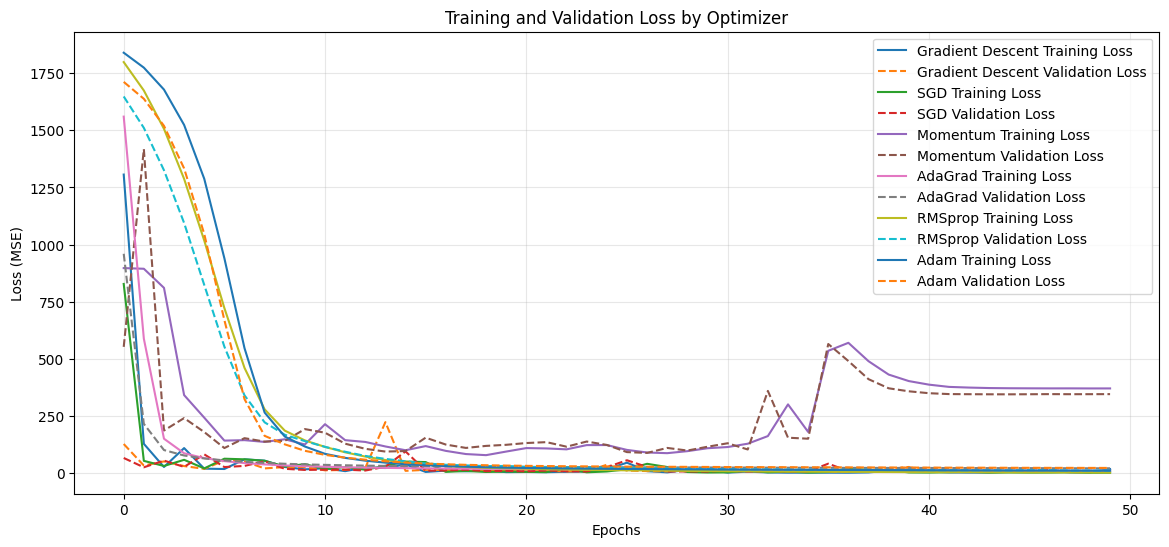

In [19]:
histories = [result['history'] for result in optimizer_results]
optimizer_names = [result['optimizer'] for result in optimizer_results]
plot_training_history(histories, optimizer_names)

# 6 Hyperparameter Tunig

In [20]:
# Common model factory
def common_model(input_dim, neurons, activation, optimizer, learning_rate):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(input_dim,)))
    model.add(Dropout(0.3))
    model.add(Dense(neurons // 2, activation=activation))
    model.add(Dense(1, activation='linear'))

    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'momentum':
        opt = SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer == 'adagrad':
        opt = Adagrad(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

# scikit-learn compatible
def create_model(learning_rate=0.001, neurons=64, activation='relu', optimizer='adam'):
    return common_model(
        input_dim=X_train.shape[1],
        neurons=neurons,
        activation=activation,
        optimizer=optimizer,
        learning_rate=learning_rate
    )

# For Hyperband
def build_model(hp):
    return common_model(
        input_dim=X_train.shape[1],
        neurons=hp.Int('neurons', 32, 128, step=32),
        activation=hp.Choice('activation', ['relu', 'tanh']),
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    )

In [21]:
# Parameter search space
param_grid = {
    'model__learning_rate': [0.001, 0.01],
    'model__neurons': [32, 64, 128],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'rmsprop', 'sgd', 'momentum', 'adagrad'],
    'batch_size': [16, 32],
    'epochs': [50]
}

search_spaces = {
    'model__learning_rate': Real(1e-4, 1e-3, 'log-uniform'),
    'model__neurons': Integer(32, 128),
    'model__activation': Categorical(['relu', 'tanh']),
    'model__optimizer': Categorical(['adam', 'rmsprop', 'sgd', 'momentum', 'adagrad']),
    'batch_size': Integer(16, 32),
    'epochs': Integer(25, 50)
}

## 6.1 Random Search

In [22]:
random_search_model = KerasRegressor(model=create_model, verbose=0)
random_search = RandomizedSearchCV(random_search_model, param_distributions=param_grid, n_iter=10, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

print("Performing Random Search...")
random_search_start = time.time()
random_search_result = random_search.fit(X_train, y_train)
random_search_time = time.time() - random_search_start

print("="*100)
print(f"Best parameters found: {random_search_result.best_params_}")
print(f"Best MSE score: {-random_search_result.best_score_:.4f}")
print(f"Time taken: {random_search_time:.2f} seconds")

Performing Random Search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


2025-04-24 21:17:49.306737: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 21:17:49.312128: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 21:17:49.327271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745504269.356094 3458696 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-24 21:17:49.363641: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 21:17:49.363641: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
E0000 00:00:1745504269.

Best parameters found: {'model__optimizer': 'adam', 'model__neurons': 64, 'model__learning_rate': 0.01, 'model__activation': 'tanh', 'epochs': 50, 'batch_size': 16}
Best MSE score: 2.4736
Time taken: 30.42 seconds


## 6.2 Grid Search

In [23]:
grid_search_model = KerasRegressor(model=create_model, verbose=0)
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

print("Performing Grid Search...")
grid_search_start = time.time()
grid_search_result = grid_search.fit(X_train, y_train)
grid_search_time = time.time() - grid_search_start

print("="*100)
print(f"Best parameters found: {grid_search_result.best_params_}")
print(f"Best MSE score: {-grid_search_result.best_score_:.4f}")
print(f"Time taken: {grid_search_time:.2f} seconds")

Performing Grid Search...
Fitting 3 folds for each of 120 candidates, totalling 360 fits


/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Best parameters found: {'batch_size': 16, 'epochs': 50, 'model__activation': 'tanh', 'model__learning_rate': 0.001, 'model__neurons': 64, 'model__optimizer': 'sgd'}
Best MSE score: 1.1253
Time taken: 233.53 seconds


## 6.4 Bayesian Search

In [24]:
bayes_search_model = KerasRegressor(model=create_model, verbose=0)
bayes_search = BayesSearchCV(bayes_search_model, search_spaces=search_spaces, n_iter=10, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

print("Performing Bayesian Optimization...")
bayes_search_start = time.time()
bayes_search_result = bayes_search.fit(X_train, y_train)
bayes_search_time = time.time() - bayes_search_start

print("="*100)
print(f"Best parameters found: {bayes_search_result.best_params_}")
print(f"Best MSE score: {-bayes_search_result.best_score_:.4f}")
print(f"Time taken: {bayes_search_time:.2f} seconds")

Performing Bayesian Optimization...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intermaniak/AdvMath_MidtermProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Best parameters found: OrderedDict({'batch_size': 24, 'epochs': 34, 'model__activation': 'tanh', 'model__learning_rate': 0.00046629977170738445, 'model__neurons': 42, 'model__optimizer': 'momentum'})
Best MSE score: 3.8555
Time taken: 34.46 seconds


## 6.4 Hyperband

In [25]:
print("Performing Hyperband Search...")
tuner = Hyperband(build_model, objective='val_loss', max_epochs=50, factor=3, directory='hyperband_dir', project_name='hyperparam_compare')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
hyperband_start = time.time()
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping], verbose=0)
hyperband_time = time.time() - hyperband_start
best_hyperparams = tuner.get_best_hyperparameters(1)[0]

print("="*100)
print(f"Best parameters found: {best_hyperparams.values}")
best_model = tuner.hypermodel.build(best_hyperparams)
best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=0)
y_pred_hyperband = best_model.predict(X_test)
hyperband_mse = mean_squared_error(y_test, y_pred_hyperband)
print(f"Best MSE score: {hyperband_mse:.4f}")
print(f"Time taken: {hyperband_time:.2f} seconds")

Performing Hyperband Search...
Reloading Tuner from hyperband_dir/hyperparam_compare/tuner0.json
Best parameters found: {'neurons': 96, 'activation': 'tanh', 'optimizer': 'sgd', 'learning_rate': 0.0032565665816327726, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0046'}
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Best MSE score: 1.2962
Time taken: 0.00 seconds


## 6.5 Tuning Comparison


Hyperparameter Tuning Methods Comparison:


,Method,MSE,Time (s)
1,Grid Search,1.125266,233.532920
3,Hyperband,1.296204,0.000501
0,Random Search,2.473551,30.420118
2,Bayesian Optimization,3.855542,34.459663


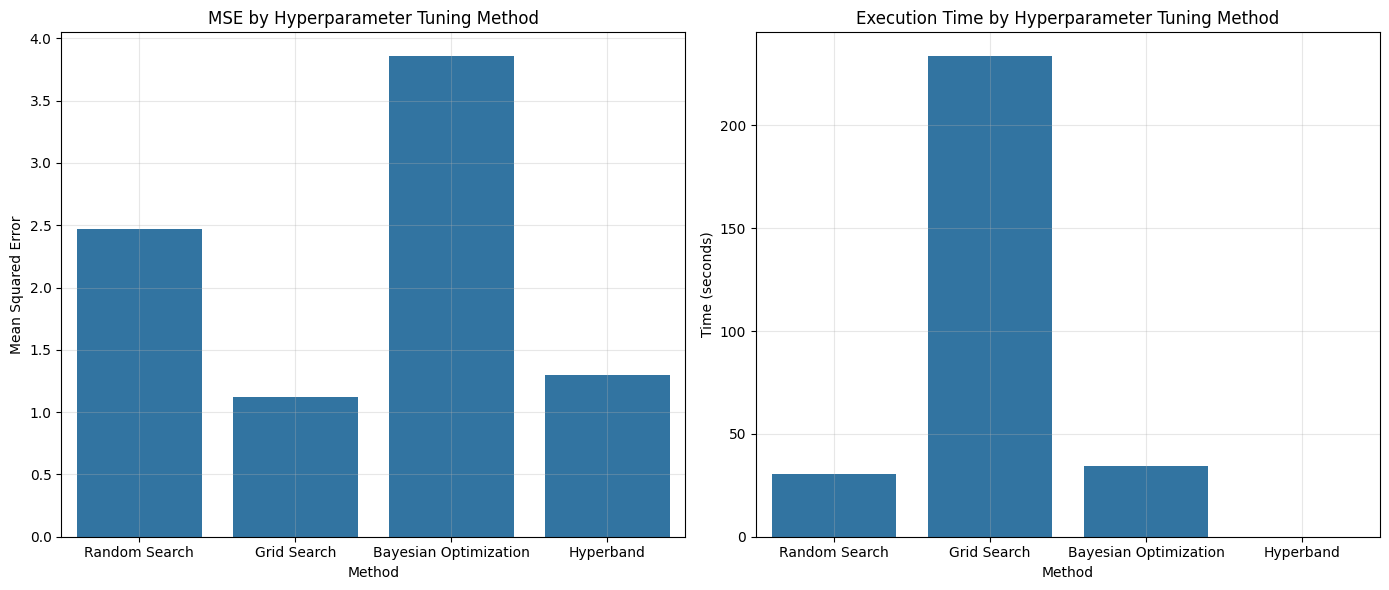

In [26]:
tuning_comparison = pd.DataFrame([
    {'Method': 'Random Search', 'MSE': -random_search_result.best_score_, 'Time (s)': random_search_time},
    {'Method': 'Grid Search', 'MSE': -grid_search_result.best_score_, 'Time (s)': grid_search_time},
    {'Method': 'Bayesian Optimization', 'MSE': -bayes_search_result.best_score_, 'Time (s)': bayes_search_time},
    {'Method': 'Hyperband', 'MSE': hyperband_mse, 'Time (s)': hyperband_time}
])

print("\nHyperparameter Tuning Methods Comparison:")
display(tuning_comparison.sort_values('MSE'))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Method', y='MSE', data=tuning_comparison)
plt.title('MSE by Hyperparameter Tuning Method')
plt.ylabel('Mean Squared Error')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.barplot(x='Method', y='Time (s)', data=tuning_comparison)
plt.title('Execution Time by Hyperparameter Tuning Method')
plt.ylabel('Time (seconds)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7 Final Model Evaluation with Best Parameters

## 7.1 Build Final Model

In [27]:
final_params = grid_search_result.best_params_
print(f"Building final model with parameters: {final_params}")

final_model = create_model(
    learning_rate=final_params['model__learning_rate'],
    neurons=final_params['model__neurons'],
    activation=final_params['model__activation'],
    optimizer=final_params['model__optimizer']
)

final_model.fit(
    X_train, y_train,
    batch_size=final_params['batch_size'],
    epochs=final_params['epochs'],
    validation_split=0.2,
    verbose=0
)

y_pred_final = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred_final)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, y_pred_final)
final_r2 = r2_score(y_test, y_pred_final)

print("\nFinal Model Evaluation:")
print(f"Mean Squared Error: {final_mse:.4f}")
print(f"Root Mean Squared Error: {final_rmse:.4f}")
print(f"Mean Absolute Error: {final_mae:.4f}")
print(f"R² Score: {final_r2:.4f}")

Building final model with parameters: {'batch_size': 16, 'epochs': 50, 'model__activation': 'tanh', 'model__learning_rate': 0.001, 'model__neurons': 64, 'model__optimizer': 'sgd'}
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Final Model Evaluation:
Mean Squared Error: 1.3720
Root Mean Squared Error: 1.1713
Mean Absolute Error: 0.8947
R² Score: 0.9963


## 7.2 Visualize predictions

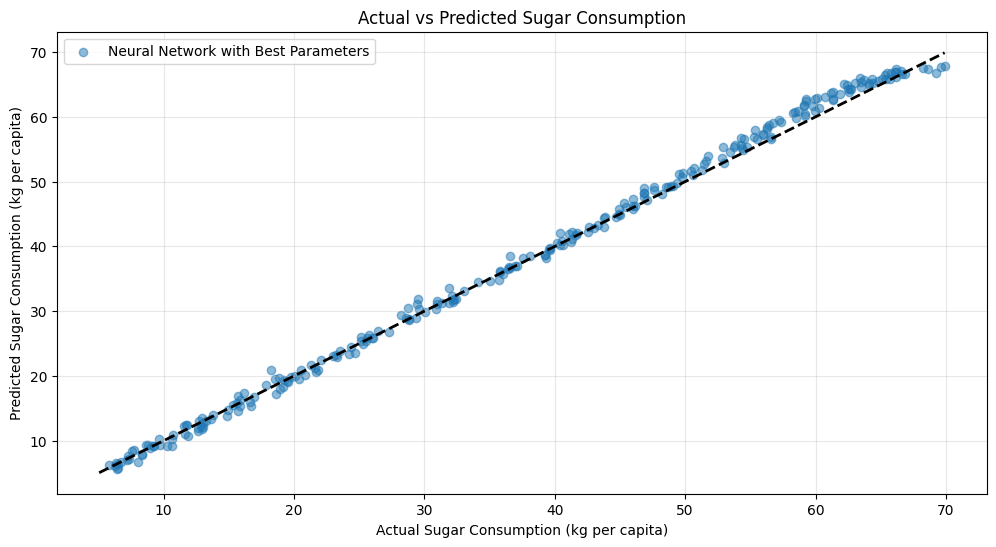


Optimization Methods Ranking (by performance):


,Optimizer,MSE,R²,Training Time (s)
1,SGD,4.559812,0.987544,3.075062
0,Gradient Descent,6.677909,0.981759,3.038545
4,RMSprop,10.129588,0.972330,3.132962
3,AdaGrad,17.932614,0.951016,3.079851
5,Adam,20.402971,0.944268,3.345770
2,Momentum,358.634035,0.020361,3.213576



Hyperparameter Tuning Methods Ranking (by performance):


,Method,MSE,Time (s)
1,Grid Search,1.125266,233.532920
3,Hyperband,1.296204,0.000501
0,Random Search,2.473551,30.420118
2,Bayesian Optimization,3.855542,34.459663


In [28]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_final, alpha=0.5, label='Neural Network with Best Parameters')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Sugar Consumption (kg per capita)')
plt.ylabel('Predicted Sugar Consumption (kg per capita)')
plt.title('Actual vs Predicted Sugar Consumption')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nOptimization Methods Ranking (by performance):")
display(comparison_df.sort_values('MSE'))

print("\nHyperparameter Tuning Methods Ranking (by performance):")
display(tuning_comparison.sort_values('MSE'))